# Figure 006 (v001)

Baseline and RNA-associated essentiality.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Sequence, TypeVar

import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text
from scipy.cluster.hierarchy import leaves_list, linkage

In [3]:
import speclet.plot as sp
from speclet.io import figure_img_file, tables_dir
from speclet.plot.color_pal import pal_to_legend_handles

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sp.set_speclet_theme(sp.PlottingMode.DISSERTATION)

In [5]:
FIGNUM, VERSION = 6, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "essentiality")
FIGURE_FILE

PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/figures/figure_006-v001/fig_006-v001_essentiality.png')

In [6]:
notebook_output_dir = tables_dir() / "100_015_essentiality_comparisons"

In [7]:
T = TypeVar("T")

### Data

In [8]:
enrichr_res = pd.read_csv(notebook_output_dir / "variable-rna-effect-top-var.csv")
rna_corr = pd.read_csv(notebook_output_dir / "rna-variable-correlations.csv").set_index(
    "lineage_subtype"
)
mu_a_corr = pd.read_csv(
    notebook_output_dir / "mu_a-variable-correlations.csv"
).set_index("lineage_subtype")

genes_data = pd.read_csv(
    notebook_output_dir / "specific-gene-data.csv", low_memory=False
)
genes_mu_dfs = pd.read_csv(
    notebook_output_dir / "computed-rna-expression-effect.csv", low_memory=False
)

## Figure

### Shared

In [9]:
FIGSIZE = (6.5, 7)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
subfigures = figure.subfigures(nrows=2, ncols=1, height_ratios=(1.2, 1))

top_panels = subfigures[0].subfigures(ncols=2)
panel_a = top_panels[0]
panel_b = top_panels[1]
bottom_panels = subfigures[1].subfigures(ncols=2, width_ratios=(2, 3))
panel_c = bottom_panels[0]
panel_d = bottom_panels[1]

<Figure size 650x700 with 0 Axes>

### a. Correlation of $\mu_a$ across models

In [10]:
def hclust(x: pd.DataFrame) -> pd.DataFrame:
    clustering = linkage(x, method="average", metric="euclidean", optimal_ordering=True)
    y = x.copy().iloc[leaves_list(clustering), leaves_list(clustering)]
    return y

In [11]:
def extract_subtype(t: str) -> str:
    if "(" not in t:
        return t
    return t.split("(")[1].replace(")", "").strip()


def extract_subtype_from_label(lbl: Text) -> Text:
    lbl.set_text(extract_subtype(lbl.get_text()))
    return lbl


def extract_subtype_from_labels(lbls: Sequence[Text]) -> list[Text]:
    return [extract_subtype_from_label(lbl) for lbl in lbls]

In [12]:
panel_a.clear()
panel_a.text(0, 0.98, "a", fontsize=8, fontweight="bold")
ax = panel_a.subplots()

clustered_mu_a = hclust(mu_a_corr)
sns.heatmap(
    clustered_mu_a,
    square=True,
    cmap="seismic",
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    xticklabels=1,
    yticklabels=False,
    cbar=True,
    cbar_kws={"pad": 0.02},
)
ax.tick_params("x", labelsize=5)
lbls = extract_subtype_from_labels(ax.get_xticklabels())
ax.set_xticklabels(labels=lbls)
ax.set_ylabel("cell line lineages")
ax.set_xlabel(None)
ax.set_title(r"Correlation of intercepts $\mu_a$")

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)

### b. Correlation of $b$ across models

In [13]:
panel_b.clear()
panel_b.text(0, 0.98, "b", fontsize=8, fontweight="bold")
ax = panel_b.subplots()

clustered_rna = hclust(rna_corr)
sns.heatmap(
    clustered_rna,
    square=True,
    cmap="seismic",
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    xticklabels=1,
    yticklabels=False,
    cbar=True,
    cbar_kws={"pad": 0.02},
)
ax.tick_params("x", labelsize=5)
lbls = extract_subtype_from_labels(ax.get_xticklabels())
ax.set_xticklabels(labels=lbls)
ax.set_ylabel("cell line lineages")
ax.set_xlabel(None)
ax.set_title("Correlation of RNA effects $b$")

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)

### c. Enrichr results

In [14]:
panel_c.clear()
panel_c.text(0, 0.98, "c", fontsize=8, fontweight="bold")
ax = panel_c.subplots()

plot_df = (
    enrichr_res.sort_values("adjusted_p_value")
    .assign(neglog_adjpval=lambda d: -np.log10(d["adjusted_p_value"]))
    .query("adjusted_p_value < 0.01")
)
rm_terms = ["disease", "sclerosis", "ataxia", "Diabetic"]
for rm_term in rm_terms:
    plot_df = plot_df.filter_string("term", rm_term, complement=True)

sns.barplot(
    data=plot_df.head(20),
    x="neglog_adjpval",
    y="term",
    color="salmon",
    ax=ax,
    alpha=0.5,
)
ylabels = [x.get_text() for x in ax.get_yticklabels()]
ax.set_yticklabels([])
for i, ylabel in enumerate(ylabels):
    ax.text(1, i, ylabel, size=7, ha="left", va="center")

ax.set_xlabel(r"$-\log_{10}$ adj. $p$-value")
ax.set_ylabel(None)

Text(0, 0.5, '')

### d. Examples of different RNA effects

In [15]:
def _tidy_pal_labels(pal: dict[str, T]) -> dict[str, T]:
    new_pal = {}
    for k, v in pal.items():
        if "(" in k:
            k = k.split("(")[1].replace(")", "").strip()
        new_pal[k] = v
    return new_pal


def plot_prediction_over_rna(
    gene: str,
    lineages: list[str],
    obs_data: pd.DataFrame,
    pred_data: pd.DataFrame,
    ax: plt.Axes | None = None,
    pal: dict[str, Any] | None = None,
) -> None:
    obs_df = (
        obs_data.copy()
        .query(f"hugo_symbol == '{gene}'")
        .filter_column_isin("lineage_subtype", lineages)
        .reset_index(drop=True)
    )
    pred_df = (
        pred_data.query(f"hugo_symbol == '{gene}'")
        .filter_column_isin("lineage_subtype", lineages)
        .reset_index(drop=True)
    )

    if pal is None:
        colors = sns.color_palette("Set1", len(lineages))
        pal = {ln: c for ln, c in zip(lineages, colors)}

    xmin, xmax = obs_df["m_rna_gene"].min(), obs_df["m_rna_gene"].max()
    xmin -= np.abs(0.05 * xmin)
    xmax += 0.05 * xmax

    ymin, ymax = obs_df["lfc"].min(), obs_df["lfc"].max()
    ymin -= np.abs(0.05 * ymin)
    ymax += 0.05 * ymax

    if ax is None:
        _, ax = plt.subplots(figsize=(3, 3))

    sns.scatterplot(
        data=obs_df,
        x="m_rna_gene",
        y="lfc",
        hue="lineage_subtype",
        palette=pal,
        alpha=0.5,
        s=15,
        zorder=5,
        ax=ax,
    )

    ax.set_title(gene, fontsize=7, fontstyle="italic")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.get_legend().remove()
    ax.legend(
        handles=pal_to_legend_handles(
            _tidy_pal_labels(pal), lw=0, marker="o", markersize=3
        ),
        loc="upper left",
        bbox_to_anchor=(1, 1),
        title="lineage",
        handletextpad=0.5,
        handlelength=0,
    )

    for lineage in lineages:
        df = pred_df.query(f"lineage_subtype == '{lineage}'")
        ax.fill_between(
            x=df["x_rna"],
            y1=df["mu_hdi_low"],
            y2=df["mu_hdi_high"],
            alpha=0.25,
            color=pal[lineage],
            lw=0,
            zorder=10,
        )
        ax.plot(df["x_rna"], df["mu_mean"], zorder=15, c=pal[lineage])

In [21]:
panel_d.clear()
panel_d.text(0, 0.98, "d", fontsize=8, fontweight="bold")
axes = panel_d.subplots(2, 2, sharex=False, sharey=False)

rna_plots: list[tuple[str, list[str]]] = [
    ("MAK16", ["breast", "cervix (cervical squamous)", "skin (skin squamous)"]),
    ("KIF11", ["lung (SCLC)", "lung (NSCLC)"]),
    ("KRAS", ["cervix (cervical carcinoma)", "cervix (cervical squamous)"]),
    ("PCNA", ["cervix (cervical carcinoma)", "cervix (cervical squamous)"]),
]

# Generate color pal for lineages.
lineages = []
for rna_plot in rna_plots:
    lineages += list(rna_plot[1])
lineages = list(set(lineages))
lineages.sort()
colors = sns.color_palette("Dark2", len(lineages))
panel_d_pal = dict(zip(lineages, colors))


for ax, (gene, lineages) in zip(axes.flatten(), rna_plots):
    pal = {k: v for k, v in panel_d_pal.items() if k in lineages}
    plot_prediction_over_rna(
        gene=gene,
        lineages=lineages,
        obs_data=genes_data,
        pred_data=genes_mu_dfs,
        ax=ax,
        pal=pal,
    )
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.get_legend().remove()

for ax in axes[:, 0]:
    ax.set_ylabel("LFC")
for ax in axes[1, :]:
    ax.set_xlabel("mRNA (scaled)")

mod_pal = {extract_subtype(k).replace(" ", "\n"): v for k, v in panel_d_pal.items()}
leg = panel_d.legend(
    handles=pal_to_legend_handles(mod_pal, lw=0, markersize=3, marker="o"),
    title="lineage\nsubtype",
    handletextpad=0.5,
    handlelength=0,
    labelspacing=0.7,
    loc="upper left",
    bbox_to_anchor=(-0.18, 0.65),
    frameon=True,
    edgecolor="white",
)
sp.align_legend_title(leg)

## Saving

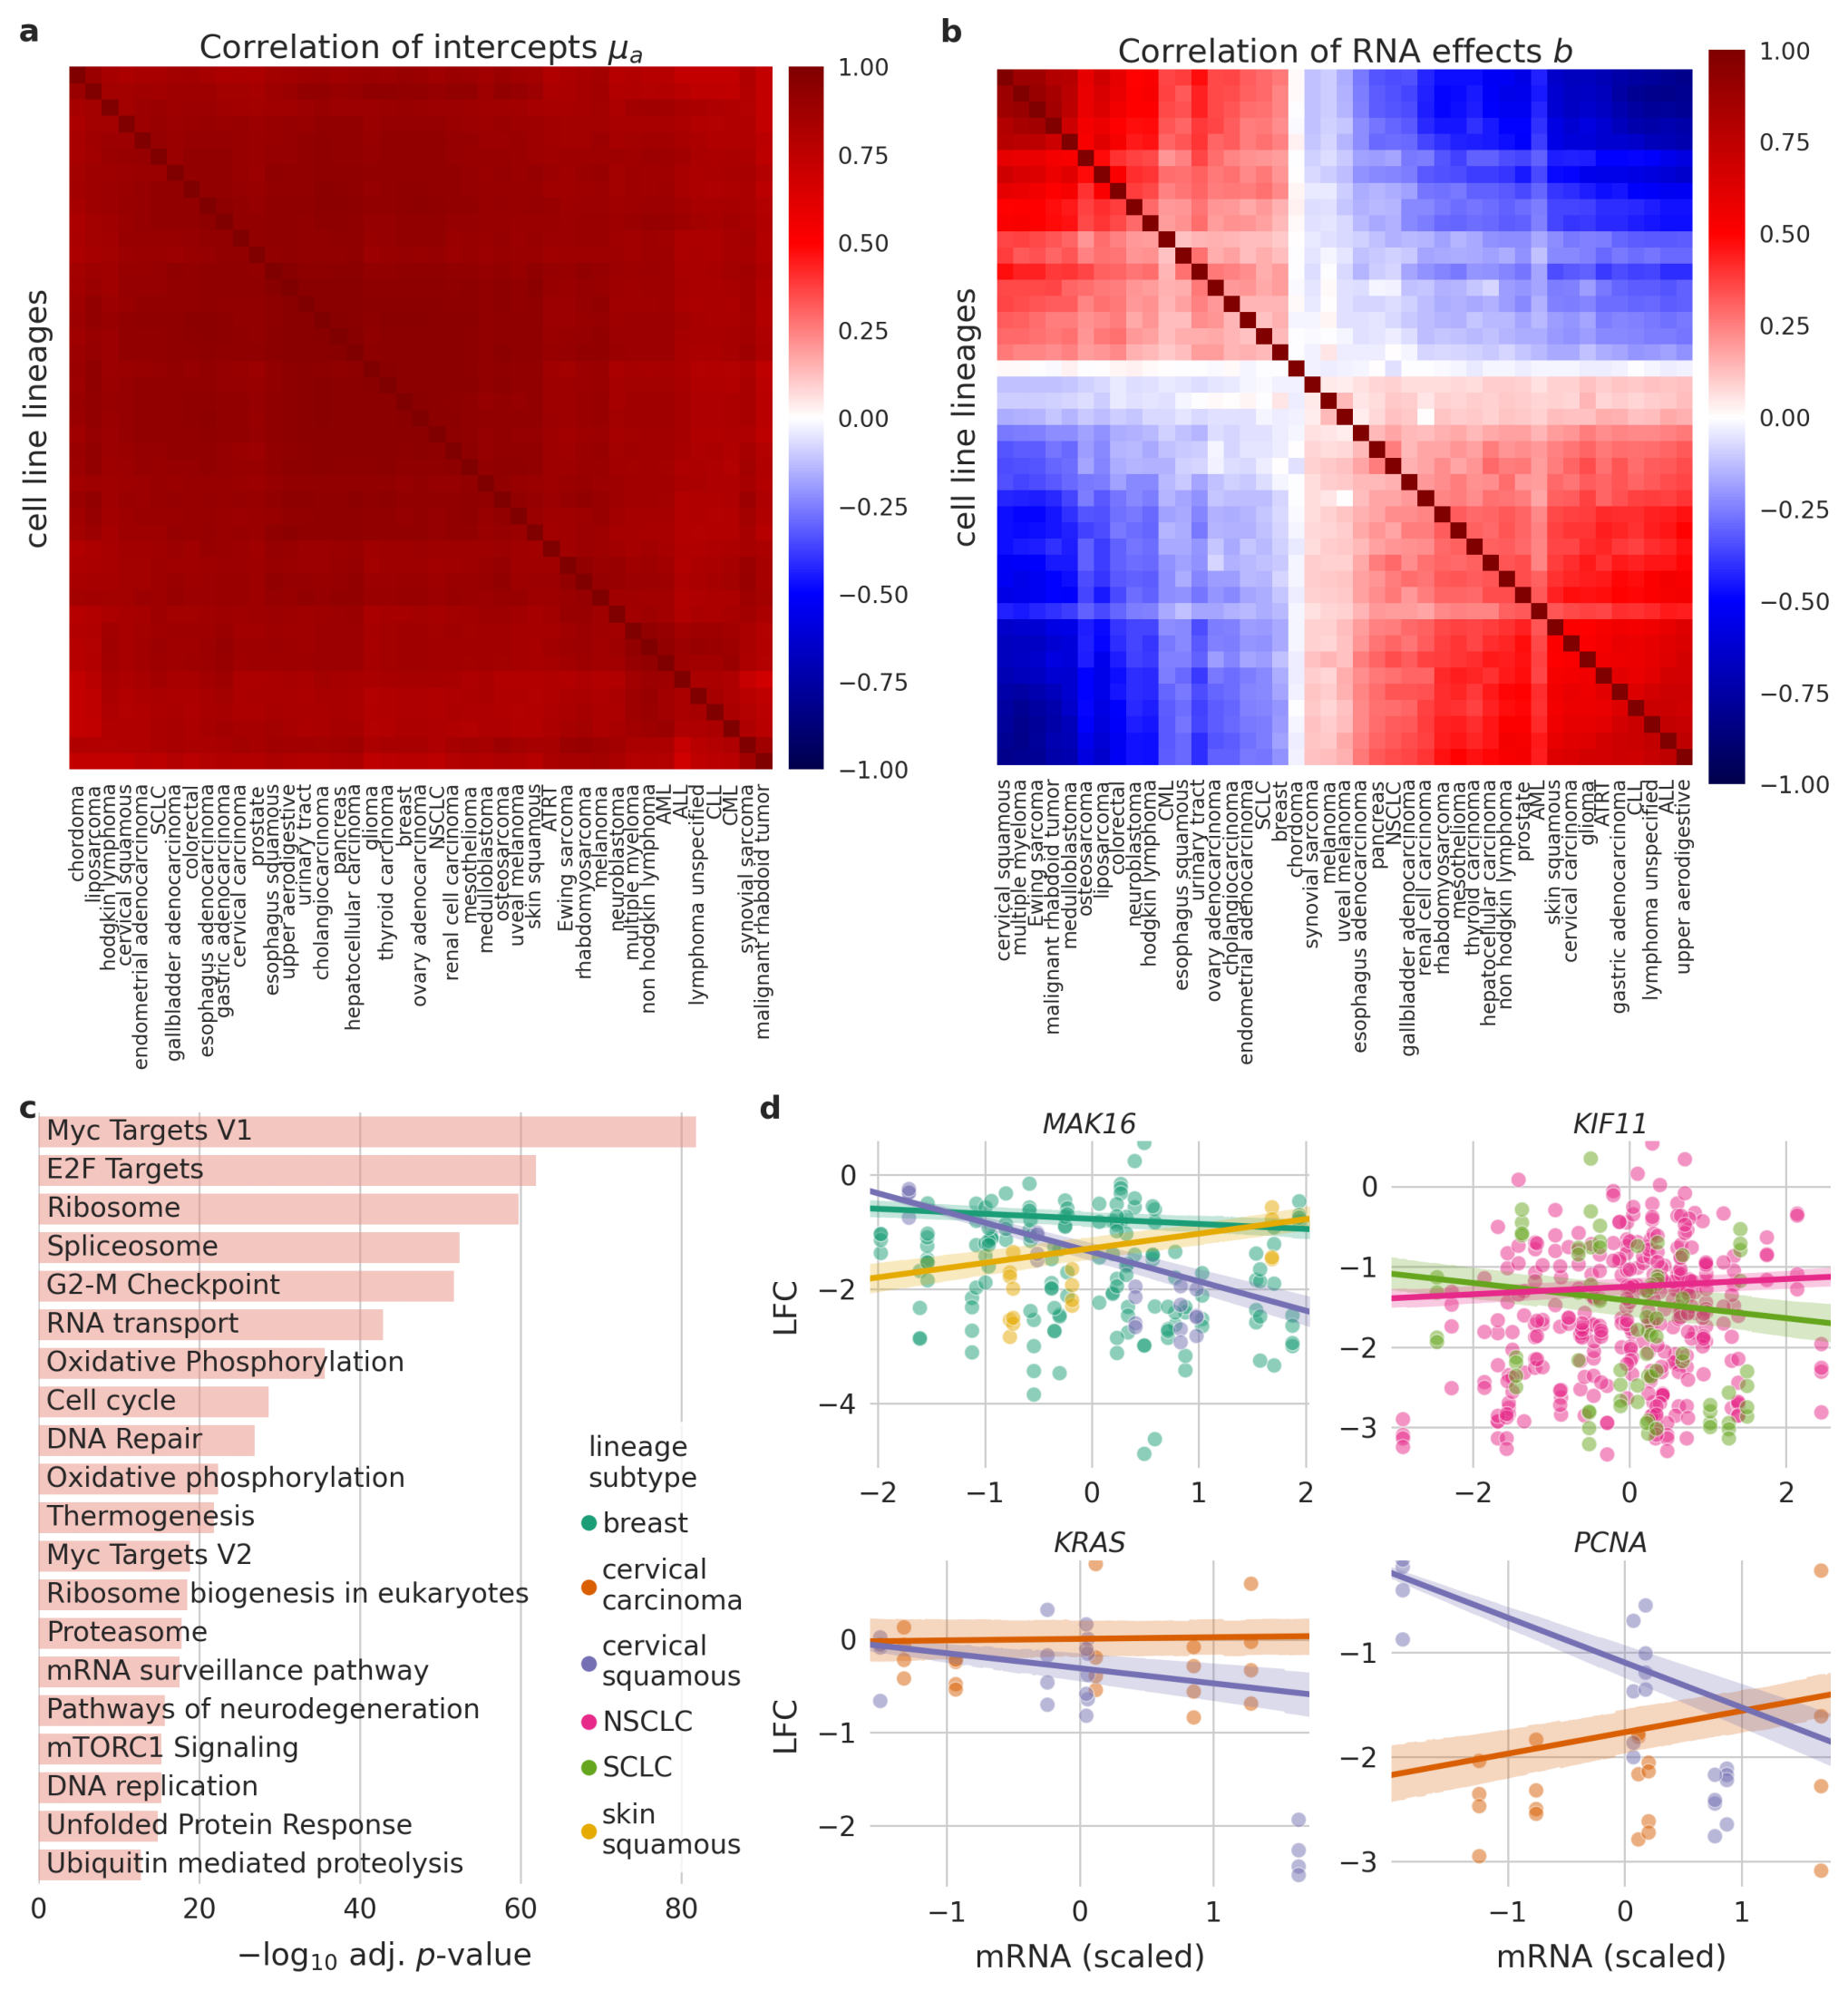

In [22]:
# Saving the figure multiple times FIXES a layout issue :shrug:
for _ in range(2):
    figure.savefig(FIGURE_FILE, dpi=100, pad_inches=0, bbox_inches="tight")
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0, bbox_inches="tight")

_, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Session Info

In [18]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-11

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-170.o2.rc.hms.harvard.edu

Git branch: figures

numpy     : 1.23.3
speclet   : 0.0.9000
seaborn   : 0.11.2
pandas    : 1.4.4
janitor   : 0.22.0
matplotlib: 3.5.3

